In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np # to use numpy arrays instead of lists
import pandas as pd # DataFrame (table)
import matplotlib.pyplot as plt # to plot
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, AveragePooling1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
!pip install keras-tuner # Install keras-tuner
import keras_tuner as kt # Now import keras_tuner

from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [2]:
def leeDatos():

    dataSet = pd.read_csv("gdrive/MyDrive/Colab Notebooks/Amazon_Unlocked_Mobile.zip", header=0, compression='zip')

    return dataSet

In [3]:
def encodeData(dataSet=0):
    dataSet.dropna(inplace=True)

    # Remove any 'neutral' ratings equal to 3
    dataSet = dataSet[dataSet['Rating'] != 3]

    # Encode 4s and 5s as 1 (rated positively)
    # Encode 1s and 2s as 0 (rated poorly)
    dataSet['Positively Rated'] = np.where(dataSet['Rating'] > 3, 1, 0)
    datos = ['Reviews', 'Positively Rated']
    misDatos = dataSet[datos]
    misDatos = misDatos.iloc[0:5000,:]

    return misDatos

In [4]:
datos = leeDatos()
print(datos)
print("\n")

encodeDatos = encodeData(datos)
print(encodeDatos)
print("\n")
print(encodeDatos['Positively Rated'].mean())
print("\n")

                                             Product Name Brand Name   Price  \
0       "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1       "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2       "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3       "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4       "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
...                                                   ...        ...     ...   
413835  Samsung Convoy U640 Phone for Verizon Wireless...    Samsung   79.95   
413836  Samsung Convoy U640 Phone for Verizon Wireless...    Samsung   79.95   
413837  Samsung Convoy U640 Phone for Verizon Wireless...    Samsung   79.95   
413838  Samsung Convoy U640 Phone for Verizon Wireless...    Samsung   79.95   
413839  Samsung Convoy U640 Phone for Verizon Wireless...    Samsung   79.95   

        Rating                         

In [5]:
ts_size = .25
trainSet, testSet = train_test_split(encodeDatos, test_size=ts_size, shuffle=False, random_state=0)
print(trainSet)
print('trainSet shape: ', trainSet.shape)
print(testSet)
print('testSet shape: ', testSet.shape)
print("\n")

                                                Reviews  Positively Rated
0     I feel so LUCKY to have found this used (phone...                 1
1     nice phone, nice up grade from my pantach revu...                 1
2                                          Very pleased                 1
3     It works good but it goes slow sometimes but i...                 1
4     Great phone to replace my lost phone. The only...                 1
...                                                 ...               ...
5680  It is very good and almost as good as new. The...                 1
5681  Bought from UnlockedCellPhoneKings refurbished...                 1
5682  I bought this iphone as "new" and when i recei...                 0
5683  I'm not too interested in having the latest te...                 1
5684  Product was brand new, and was factory unlocke...                 1

[3750 rows x 2 columns]
trainSet shape:  (3750, 2)
                                                Reviews  Pos

In [6]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

training_sentences= trainSet['Reviews']
training_labels = trainSet['Positively Rated']
testing_sentences = testSet['Reviews']
testing_labels = testSet['Positively Rated']

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [8]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [9]:
model = Sequential([
                    Embedding(vocab_size, embedding_dim, input_length=max_length),
                    Conv1D(filters=2, kernel_size=3, activation='relu', name="Conv1D"),
                    AveragePooling1D(pool_size=3),
                    Flatten(),
                    Dense(2, activation='relu'),
                    Dense(1, activation='sigmoid', name="Outpul_layer")
                    ])

opt = 'adam'
loss_fun = 'binary_crossentropy'
acc = ['accuracy']

model.compile(
    optimizer = opt,
    loss = loss_fun,
    metrics = acc
    )

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1D (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Outpul_layer (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
num_epochs = 30
history = model.fit(training_padded,
                    training_labels,
                    validation_split=0.1,
                    epochs=num_epochs,
                    verbose=2)

Epoch 1/30
106/106 - 2s - 23ms/step - accuracy: 0.7093 - loss: 0.6004 - val_accuracy: 0.6560 - val_loss: 0.6086
Epoch 2/30
106/106 - 1s - 5ms/step - accuracy: 0.7093 - loss: 0.5529 - val_accuracy: 0.6560 - val_loss: 0.5669
Epoch 3/30
106/106 - 1s - 6ms/step - accuracy: 0.7105 - loss: 0.4812 - val_accuracy: 0.6853 - val_loss: 0.4957
Epoch 4/30
106/106 - 1s - 6ms/step - accuracy: 0.7834 - loss: 0.3974 - val_accuracy: 0.8213 - val_loss: 0.4325
Epoch 5/30
106/106 - 1s - 6ms/step - accuracy: 0.8652 - loss: 0.3268 - val_accuracy: 0.8560 - val_loss: 0.3889
Epoch 6/30
106/106 - 1s - 6ms/step - accuracy: 0.9170 - loss: 0.2731 - val_accuracy: 0.8800 - val_loss: 0.3592
Epoch 7/30
106/106 - 1s - 6ms/step - accuracy: 0.9490 - loss: 0.2319 - val_accuracy: 0.9013 - val_loss: 0.3386
Epoch 8/30
106/106 - 1s - 5ms/step - accuracy: 0.9665 - loss: 0.2004 - val_accuracy: 0.9067 - val_loss: 0.3212
Epoch 9/30
106/106 - 1s - 5ms/step - accuracy: 0.9784 - loss: 0.1754 - val_accuracy: 0.9173 - val_loss: 0.3096


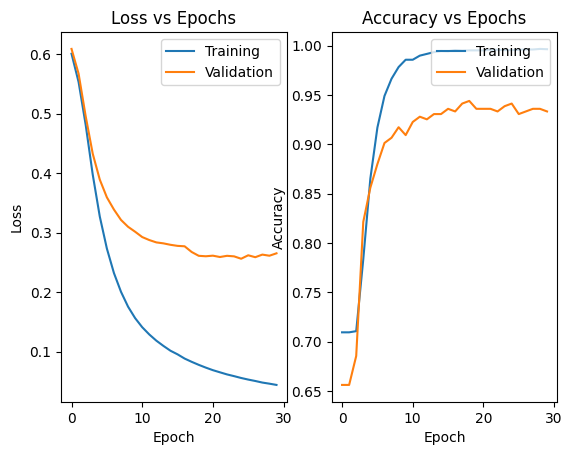

In [23]:
fig = plt.figure()
fig.add_subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss vs Epochs")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
fig.add_subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy vs Epochs")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [24]:
print(model.evaluate(training_padded, training_labels, verbose=2))
print("\n")

#### predict train data ######
df_train = pd.DataFrame()
df_train['real'] = training_labels
df_train['pred'] = model.predict(training_padded).reshape(1,len(training_padded))[0]
print(round(df_train))
print(model.evaluate(testing_padded,testing_labels, verbose=2))
print("\n")

# test data
df_test = pd.DataFrame()
df_test['real'] = testing_labels
df_test['pred'] = model.predict(testing_padded).reshape(1,len(testing_padded))[0]
print(round(df_test))


118/118 - 0s - 2ms/step - accuracy: 0.9904 - loss: 0.0652
[0.06522613018751144, 0.9904000163078308]


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
      real  pred
0        1   1.0
1        1   1.0
2        1   1.0
3        1   1.0
4        1   1.0
...    ...   ...
3745     1   1.0
3746     1   1.0
3747     0   0.0
3748     1   1.0
3749     1   1.0

[3750 rows x 2 columns]
40/40 - 0s - 2ms/step - accuracy: 0.8016 - loss: 0.8857
[0.8856895565986633, 0.8015999794006348]


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
      real  pred
0        1   1.0
1        0   0.0
2        0   0.0
3        1   1.0
4        1   0.0
...    ...   ...
1245     0   0.0
1246     1   1.0
1247     0   0.0
1248     0   0.0
1249     1   1.0

[1250 rows x 2 columns]


In [18]:
def model_builder(hp):
    vocab_size = 10000
    embedding_dim = 16
    hp_max_length = hp.Int('input_length', min_value=80, max_value=120, step=10)
    model = Sequential([
                      Embedding(vocab_size, embedding_dim, input_length=hp_max_length),
                      Conv1D(filters=2, kernel_size=3, activation='relu', name="Conv1D"),
                      AveragePooling1D(pool_size=3),
                      Flatten(),
                      Dense(2, activation='relu'),
                      Dense(1, activation='sigmoid', name="Outpul_layer")
                      ])
    opt = 'adam'
    loss_fun = 'binary_crossentropy'
    acc = ['accuracy']

    model.compile(
        optimizer = opt,
        loss = loss_fun,
        metrics = acc
        )

    return model

In [12]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     )

In [22]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [14]:
num_epochs = 30

tuner.search(training_padded,
             training_labels,
             validation_split=0.1,
             epochs=num_epochs,
             callbacks=[stop_early],
             verbose=2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""The hyperparameter search is complete.
The best 'input_length' for the embedding layer is {best_hps.get('input_length')}
""")

Trial 5 Complete [00h 00m 04s]
val_accuracy: 0.7493333220481873

Best val_accuracy So Far: 0.800000011920929
Total elapsed time: 00h 00m 24s
The hyperparameter search is complete.
The best 'input_length' for the embedding layer is 80



In [15]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(training_padded,
                    training_labels,
                    validation_split=0.1,
                    epochs=num_epochs,
                    verbose=2)

Epoch 1/30
106/106 - 3s - 25ms/step - accuracy: 0.7099 - loss: 0.6141 - val_accuracy: 0.6560 - val_loss: 0.6119
Epoch 2/30
106/106 - 1s - 10ms/step - accuracy: 0.7093 - loss: 0.5217 - val_accuracy: 0.6560 - val_loss: 0.5179
Epoch 3/30
106/106 - 1s - 6ms/step - accuracy: 0.7481 - loss: 0.4187 - val_accuracy: 0.7627 - val_loss: 0.4511
Epoch 4/30
106/106 - 1s - 6ms/step - accuracy: 0.8510 - loss: 0.3455 - val_accuracy: 0.8560 - val_loss: 0.4030
Epoch 5/30
106/106 - 1s - 6ms/step - accuracy: 0.9034 - loss: 0.2920 - val_accuracy: 0.8587 - val_loss: 0.3757
Epoch 6/30
106/106 - 1s - 6ms/step - accuracy: 0.9399 - loss: 0.2494 - val_accuracy: 0.8987 - val_loss: 0.3454
Epoch 7/30
106/106 - 1s - 6ms/step - accuracy: 0.9609 - loss: 0.2172 - val_accuracy: 0.9040 - val_loss: 0.3321
Epoch 8/30
106/106 - 1s - 5ms/step - accuracy: 0.9704 - loss: 0.1926 - val_accuracy: 0.8987 - val_loss: 0.3185
Epoch 9/30
106/106 - 0s - 5ms/step - accuracy: 0.9769 - loss: 0.1739 - val_accuracy: 0.9093 - val_loss: 0.3046

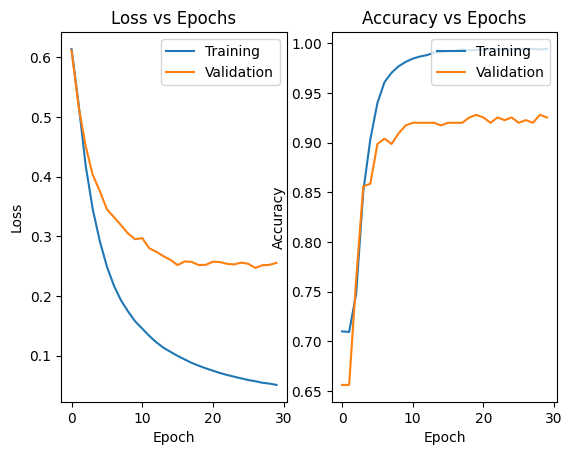

In [16]:
fig = plt.figure()
fig.add_subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss vs Epochs")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
fig.add_subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy vs Epochs")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [17]:
print(model.evaluate(training_padded, training_labels, verbose=2))
print("\n")

#### predict train data ######
df_train = pd.DataFrame()
df_train['real'] = training_labels
df_train['pred'] = model.predict(training_padded).reshape(1,len(training_padded))[0]
print(round(df_train))
print(model.evaluate(testing_padded,testing_labels, verbose=2))
print("\n")

# test data
df_test = pd.DataFrame()
df_test['real'] = testing_labels
df_test['pred'] = model.predict(testing_padded).reshape(1,len(testing_padded))[0]
print(round(df_test))

118/118 - 0s - 3ms/step - accuracy: 0.9875 - loss: 0.0699
[0.06992541253566742, 0.9874666929244995]


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
      real  pred
0        1   1.0
1        1   1.0
2        1   1.0
3        1   1.0
4        1   1.0
...    ...   ...
3745     1   1.0
3746     1   1.0
3747     0   0.0
3748     1   1.0
3749     1   1.0

[3750 rows x 2 columns]
40/40 - 0s - 3ms/step - accuracy: 0.7984 - loss: 0.8696
[0.8696238994598389, 0.7983999848365784]


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
      real  pred
0        1   1.0
1        0   0.0
2        0   1.0
3        1   1.0
4        1   1.0
...    ...   ...
1245     0   0.0
1246     1   1.0
1247     0   1.0
1248     0   1.0
1249     1   1.0

[1250 rows x 2 columns]


In [59]:
def model_builder2(hp):
    vocab_size = 10000
    hp_embedding_dim = hp.Int('embedding_dim', min_value=8, max_value=40 , step=8)
    hp_max_length = hp.Int('input_length', min_value=80, max_value=120, step=10)
    hp_filters = hp.Int('filters', min_value=2, max_value=10, step=2)
    hp_units = hp.Int('units', min_value=2, max_value=16, step=2)
    hp_activation_conv = hp.Choice('activation_conv', values=['relu', 'sigmoid', 'tanh'])
    hp_activation_dense = hp.Choice('activation_dense', values=['relu', 'sigmoid', 'tanh'])
    model = Sequential([
                      Embedding(vocab_size, hp_embedding_dim, input_length=hp_max_length),
                      Conv1D(filters=hp_filters, kernel_size=3, activation=hp_activation_conv, name="Conv1D"),
                      AveragePooling1D(pool_size=3),
                      Flatten(),
                      Dense(units=hp_units, activation=hp_activation_dense),
                      Dense(1, activation='sigmoid', name="Outpul_layer")
                      ])
    opt = 'adam'
    loss_fun = 'binary_crossentropy'
    acc = ['accuracy']

    model.compile(
        optimizer = opt,
        loss = loss_fun,
        metrics = acc
        )

    return model

In [60]:
cnn_tuner2 = kt.Hyperband(model_builder2,
                     objective='val_accuracy',
                     max_epochs=12,
                     factor=3,
                     )

Reloading Tuner from ./untitled_project/tuner0.json


In [61]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [62]:
num_epochs = 30

cnn_tuner2.search(training_padded,
             training_labels,
             validation_split=0.1,
             epochs=num_epochs,
             callbacks=[stop_early],
             verbose=2)

# Get the optimal hyperparameters
cnn_best_hps2=cnn_tuner2.get_best_hyperparameters(num_trials=1)[0]

print("""The hyperparameter search is complete.
The best input_length for the embedding layer is""", cnn_best_hps2.get('input_length'))

The hyperparameter search is complete. 
The best input_length for the embedding layer is 80


In [63]:
model_tuner = cnn_tuner2.hypermodel.build(cnn_best_hps2)

history_tuner = model_tuner.fit(training_padded,
                    training_labels,
                    validation_split=0.1,
                    epochs=num_epochs,
                    verbose=2)

Epoch 1/30
106/106 - 4s - 39ms/step - accuracy: 0.7052 - loss: 0.6490 - val_accuracy: 0.6560 - val_loss: 0.6502
Epoch 2/30
106/106 - 0s - 4ms/step - accuracy: 0.7093 - loss: 0.5959 - val_accuracy: 0.6560 - val_loss: 0.6255
Epoch 3/30
106/106 - 1s - 6ms/step - accuracy: 0.7132 - loss: 0.5655 - val_accuracy: 0.6720 - val_loss: 0.5675
Epoch 4/30
106/106 - 0s - 4ms/step - accuracy: 0.8047 - loss: 0.4433 - val_accuracy: 0.8320 - val_loss: 0.4078
Epoch 5/30
106/106 - 1s - 6ms/step - accuracy: 0.8975 - loss: 0.2819 - val_accuracy: 0.8907 - val_loss: 0.3133
Epoch 6/30
106/106 - 0s - 4ms/step - accuracy: 0.9393 - loss: 0.1893 - val_accuracy: 0.9227 - val_loss: 0.2427
Epoch 7/30
106/106 - 0s - 4ms/step - accuracy: 0.9561 - loss: 0.1395 - val_accuracy: 0.9093 - val_loss: 0.2183
Epoch 8/30
106/106 - 1s - 7ms/step - accuracy: 0.9656 - loss: 0.1106 - val_accuracy: 0.9200 - val_loss: 0.1944
Epoch 9/30
106/106 - 1s - 5ms/step - accuracy: 0.9727 - loss: 0.0889 - val_accuracy: 0.9333 - val_loss: 0.1934


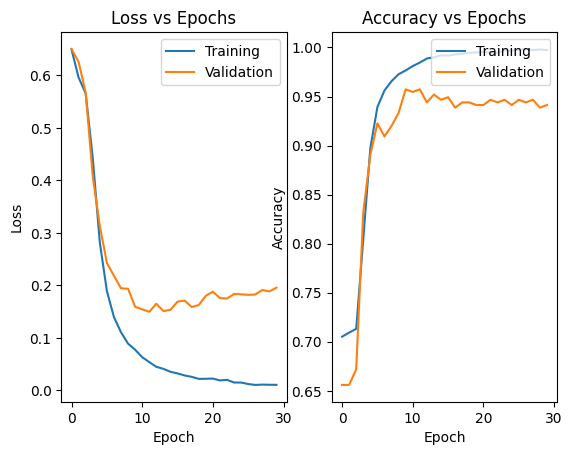

In [64]:
fig = plt.figure()
fig.add_subplot(121)
plt.plot(history_tuner.history['loss'])
plt.plot(history_tuner.history['val_loss'])
plt.title("Loss vs Epochs")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
fig.add_subplot(122)
plt.plot(history_tuner.history['accuracy'])
plt.plot(history_tuner.history['val_accuracy'])
plt.title("Accuracy vs Epochs")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [65]:
print(model_tuner.evaluate(training_padded, training_labels, verbose=2))
print("\n")

#### predict train data ######
df_train = pd.DataFrame()
df_train['real'] = training_labels
df_train['pred'] = model_tuner.predict(training_padded).reshape(1,len(training_padded))[0]
print(round(df_train))
print(model_tuner.evaluate(testing_padded,testing_labels, verbose=2))
print("\n")

# test data
df_test = pd.DataFrame()
df_test['real'] = testing_labels
df_test['pred'] = model_tuner.predict(testing_padded).reshape(1,len(testing_padded))[0]
print(round(df_test))

118/118 - 0s - 2ms/step - accuracy: 0.9931 - loss: 0.0266
[0.026639476418495178, 0.993066668510437]


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
      real  pred
0        1   1.0
1        1   1.0
2        1   1.0
3        1   1.0
4        1   1.0
...    ...   ...
3745     1   1.0
3746     1   1.0
3747     0   0.0
3748     1   0.0
3749     1   0.0

[3750 rows x 2 columns]
40/40 - 0s - 2ms/step - accuracy: 0.8384 - loss: 0.6958
[0.6958319544792175, 0.8384000062942505]


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
      real  pred
0        1   1.0
1        0   0.0
2        0   1.0
3        1   1.0
4        1   0.0
...    ...   ...
1245     0   0.0
1246     1   1.0
1247     0   0.0
1248     0   1.0
1249     1   1.0

[1250 rows x 2 columns]
